# [IAPR 2020:][iapr2020] Lab 3 ‒  Classification

**Author:** Anne-Aimée Bernard, Jonas Ulbrich, Arthur Bricq
**Due date:** 08.05.2020

[iapr2018]: https://github.com/LTS5/iapr-2018

In [1]:
import sys
sys.path.append("..")
import lab03_functions as imPro 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import importlib
importlib.reload(imPro)
import os
import numpy as np
import itertools
from sklearn import mixture


## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.




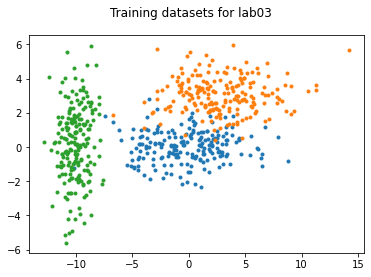

In [2]:
a,b,c, = imPro.get_matlab_data()
datasets = [a,b,c]
fig, ax = plt.subplots() 
for data in datasets:
    ax.plot(data[:,0],data[:,1],'.')
fig.suptitle('Training datasets for lab03');    

### 1.1 Bayes method
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

The Bayesian classification is evaluated using a probabilistic approach, to assign a data $x$ to the most probable class $w$, using the Bayesian rule $P(w_i|x)= \frac{p(x |w_i) P(w_i)}{p(x)}$.
The data is assigned using the maximum a posteriori probability : $P(w_1|x)<>P(w_2|x)$.

We use the hypothesis that pdf follow 2D-Gaussian laws, and will establish the following discriminant function for each class a,b and c : $g_i(x)= lnP(w_i)-0.5 x^T \sum_i^{-1}x + 0.5 x^T \sum_i^{-1}\mu_i - 0.5 \mu_i^T \sum_i^{-1}\mu_i + 0.5 \mu_i^T \sum_i^{-1}x+c_i $. The covariance matrixes and averages of the classes have been approximated to the closest integer values, to simplify the calculations. The discriminant functions allow to draw the decision curves between two classes $i$ and $j$ : $g_i-g_j=0$.
The first term $lnP(w_i)$ could be easily removed here since all the classes have the same size, so $P(a)=P(b)=P(c)$.

$ \mu_a=\left(\begin{array}{cc} 0 \\0\end{array}\right)$ ; $\sum_a=\left(\begin{array}{c} 10 & 0\\0 & 1\end{array}\right)$ ; 
$g_a(x)=\frac{1}{2}[-0.1x^2 -y^2]$

$ \mu_b=\left(\begin{array}{cc} 3 \\3\end{array}\right)$ ; $\sum_b=\left(\begin{array}{c} 10 & 0\\0 & 1\end{array}\right)$ ; 
$g_b(x)=\frac{1}{2}[-0.1x^2 -y^2+0.6x+6y-9.9]$

$ \mu_c=\left(\begin{array}{cc} -10 \\0\end{array}\right)$ ; $\sum_c=\left(\begin{array}{c} 1 & 0\\0 & 5\end{array}\right)$ ; 
$g_c(x)=\frac{1}{2}[-x^2 -0.2y^2-20x-100]$

With these class parameters, we can easily identify the classes on the plot. Classes a and b have similar distribution (see the covariance matrix) and different means : class a is the bottom right class, class b is the top right class and class c is the class on the left of the plot. 

Class c has a very different covariance function compared to a and b. For the separation curves between c and a, c and b, we will use the complete discriminant function and the decision curves should be quadratics. The separation curves are here hyperbolas.

$g_{ac}=\frac{1}{2}[0.9x^2-0.8y^2+20x+100]=0$, which gives the analytical expression : $y^2=1.1x^2+25x+125$

$g_{bc}=\frac{1}{2}[0.9x^2-0.8y^2+20.6x+6y+90.1]=0$, which gives the analytical expression : $0.8y^2-6y=0.9x^2+20.6x+90.1$

Classes a and b have similar covariance functions $\sum_a = \sum_b=\sum$. 
We can then use following simplified discriminant functions : $g_i(x)=\sum^{-1} \mu_i x + lnP(w_i)-0.5 \mu_i^T \sum^{-1}\mu_i $
so the separation curve defined by $g_a-g_b=0$ between these two classes is linear : 
$g_{ab}=\frac{1}{2}[-0.6x -6y+9.9]$, equivalent as $y=-0.1x+1.6$. The decision curve is a hyperplane.

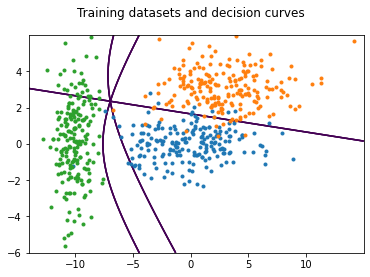

In [3]:
a,b,c, = imPro.get_matlab_data()
datasets = [a,b,c]

delta = 0.025
xrange = np.arange(-14.0, 15.0, delta)
yrange = np.arange(-6.0, 6.0, delta)
x,y = np.meshgrid(xrange,yrange)

fig, ax = plt.subplots() 
for data in datasets:
    ax.plot(data[:,0],data[:,1],'.')
    ax.plot(x,0*x+1.6,label='decision curve a/b')
    g_ab= 0.5*(-0.6*x -6*y+9.9) # between a and b (top and bottom right)
    g_ac= 0.5*(0.9*x**2-0.8*y**2 +20*x +100) # between a and c (left and bottom right)
    g_bc= 0.5*(0.9*x**2-0.8*y**2 +20.6*x +6*y+90.1) # between b and c (left and top right)
    plt.contour(x,y, g_ab, [0])
    plt.contour(x,y, g_ac, [0])
    plt.contour(x,y, g_bc, [0])
fig.suptitle('Training datasets and decision curves');   

### 1.2 Gaussian Mixture Model for classification: Model selection

Now that we have discussed some simple cases of bayesian methods to draw separation lines, it's possible to use some more complex techniques to have a good classifier. First, let's build a good **class model** !

The next block of code is an illustration of how we can compute a **Gaussian Mixture Model** using the library *scikit-learn.mixture*. Once we have a training dataset, it is extremely simple to build a bayesian estimation of this model using GMM. However, this model has several **hyper-parameters** such as 
- the number of components per classes.
- type of covariance matrix.

Those hyper-parameters are used to create the models 'behind' each classes. **Model selection** can be difficult and using a metric to define what a good model is could be very useful. 

BIC, standing for *Bayesian information criterion*, which is an indicator used for model selection. It is based on the likelihood function which takes into account the number of parameters (to avoid overfitting...)

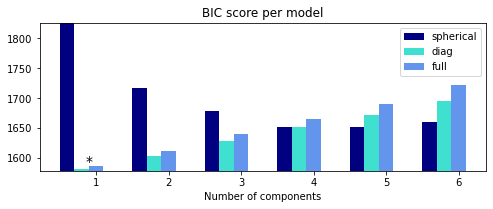

In [4]:
X = a
bic = []
lowest_bic = np.infty
n_components_range = range(1, 7)
cv_types = ['spherical',  'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue'])
bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +.2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types);


On the above plot, we see a really iteresting information: the best model of all the 24 tested ones is a model with **a single component per classes** using **diagonal covariance matrix**. This is a very simple model, however it is the best suited to this dataset. So let's use this. 

Now that we have some more confidence in our model, let's make another classifier. 

## 1.3 Mahalanobis Distance

The Mahalanobis distance is defined between a point $x$ and a gaussian distribution with mean $\mu$ and covariance matrix $C$ by $$d_{maha} = \sqrt{(x-\mu)^T C^{-1} (x-\mu)}$$

Let us make an arrangement of this formula for computation efficiency using *numpy*'s potential to deal with matrixes.

$d_{maha}^2 = (x-\mu)^T C^{-1} (x-\mu) = ((C^{-1})^T(x-\mu))^T (x-\mu ) = y \cdot x = \sum{x_iy_i}$ where $y$ is defined by $y = (C^{-1})^T(x-\mu)$

Using this observation, we make the following function which can take as input the initial dataset.

In [5]:
def mahalanobis(gmm, points):
    """
    Compute the mahalanobis distance of a dataset of points from a GMM

    Parameters
    ----------
    gmm : GMM 
        GMM of the model.
    points : np.array of size (N,2) where N is the number of point 
        All the data points to be used.

    Returns
    -------
    TYPE
        DESCRIPTION.

    """
    mean = gmm.means_[0] 
    cov = np.diag(gmm.covariances_[0])
    # cov = np.eye(2) 
    v = (points - mean).T
    y = v.T.dot(np.linalg.inv(cov))    
    scalar = (y * v.T).sum(axis = 1)
    return np.sqrt(scalar)


We can now test this classifier using the following block of code. First, it will *randomly separate* the datasets into a training dataset and a testing dataset. 
Then, it will use the training dataset to *build a gaussian model* based on a *unique gaussian with diagonal covariance matrix*. 
Finally, it will go through the testing points and try to classify each one of them using the mahalanobis distance, as following. The label $c$ of each testing point is $$c(x) =   \underset{k}{\operatorname{argmin}} d_{maha}(gmm_k,x) $$
Finally, the results of the classification using this classifier are plotted in a graph which marks by 'x' the points misclassified.

The overall accuracy of the model is 116 successes over 120 testing samples


Text(-4.772884507354674, 6.347645114883957, 'Class 2: 0.9666666666666667 success rate')

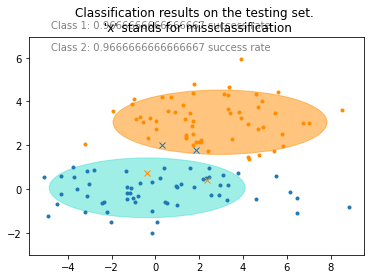

In [6]:
datasets = [a,b]

# 1. Split the data 
training_sets, testing_sets = [], []
for dataset in datasets: 
    training, testing = imPro.split_dataset(dataset = dataset, training_ratio = 0.7)
    training_sets.append(training)
    testing_sets.append(testing)
    
# 2. Fit the GMM on the training datasets
gmms = []
for dataset in training_sets:
    gmm = mixture.GaussianMixture(n_components=1, covariance_type='diag')
    gmm.fit(dataset)
    gmms.append(gmm)

# 3. Test: evaluate Mahalanobis distance to perform classification of testing points
classification_results = []
for i, dataset in enumerate(testing_sets):
    distances = np.array([mahalanobis(gmm, dataset) for gmm in gmms])
    predicts = np.argmin(distances, axis = 0)
    corrects = predicts == i 
    classification_results.append(corrects)
    
classification_results = np.array(classification_results)
non_zero = np.count_nonzero(classification_results)
elements = classification_results.size
p1 = np.count_nonzero(classification_results[0,:])/classification_results[0,:].size
p2 = np.count_nonzero(classification_results[1,:])/classification_results[1,:].size
print("The overall accuracy of the model is {} successes over {} testing samples".format(non_zero, elements))

# 4. Plotting the results 
fig, ax = plt.subplots()
colors = ['turquoise', 'darkorange']
imPro.make_ellipses(gmms[0], ax, colors[0])
imPro.make_ellipses(gmms[1], ax, colors[1])
colors = ['tab:blue', 'darkorange']
for i, dataset in enumerate(testing_sets):
    for j, data in enumerate(dataset):
        f = '.' if classification_results[i,j] else 'x'
        ax.plot(data[0],data[1],f,color = colors[i])
ax.set_title('Classification results on the testing set. \n \'x\' stands for missclassification')
x, y = ax.get_xlim()[0], ax.get_ylim()[1]+1
ax.text(x + 1, y, "Class 1: {} success rate".format(p1),{'color':'gray'})
ax.text(x + 1, y - 1, "Class 2: {} success rate".format(p2),{'color':'gray'})

## Discussion

The Mahanalobis distance is very interesting because it takes into account the variance of the data in the metric. A point that that is very far away (in the euclidian meaning) from the center but on a direction of very high variance will be treated as close as a point that is quite close from the center, but on a direction with little variance. 

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python.

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [7]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

data_base_path = os.path.join(os.pardir, 'lab03\lab-03-data')

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [8]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path,'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

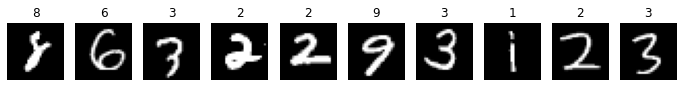

In [9]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP
The difficult part about a MLP is it creation from scratch, implementing the
activation functions, backpropagation and so forth. But if done correclty, once
such a class is completed, it is easy to implement. This can be seen in the
code below, wich uses the MLP class of scikit-learn. Here it is important to
understand the data format that is fed to the NN to make it work correctly.
Additionally it is useful to knoww how the different parameters can be changed.
Looking at the default values of the classifier we see that the only hidden
layer set by default has alread 100 neurons, wich is what is required for this
exercise (so no modification is needed). The input layer is defined through
dimention of the samples (28x28=784) and similarly the output layer is defined
by the number of nuique labels. Additional parameters could be changed to see
how the performances vary. For example the activation function could be changed
to tanh. However, leaving everything by default works just fine for this 
classification problem, so no parameters were overwritten.


Before using a NN one needs to train it. This is done by calling the code line
`MLP.fit(X,y)`. Some parameters are important such as:
- activation function: relu
- hidden layers: 1 hidden layer with 100 neurons
- ...

However, those are already set by default. The definition of those parameters could be overwritten by passing the parameters with the according keywords to the class constructor (`MLPClassifier(parameter='value')`). For more details see the [reference][ref-link]

[ref-link]:https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

In [10]:
from sklearn.neural_network import MLPClassifier

#prepare data
X=imPro.rearrange_img_stack(train_images,z_stack=False)
y=train_labels
#define classifier object, note that all hyperparameters are set to default
MLP=MLPClassifier()
#train MLP
MLP.fit(X,y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

Now it is time to test the neural network's performances: The result shows how easely a good classification can be obtained with MLPs, Nonetheless, this fits are potentially sensitive to noise and should therfore be applied keeping this in mind.


96.45% of the estimated labels are correct


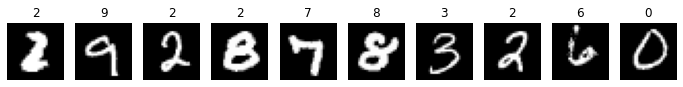

In [11]:
X_test=imPro.rearrange_img_stack(test_images,z_stack=False)
y_test=test_labels
y_est=MLP.predict(X_test)

#compute percentage of correct labels
corr_pc=100*np.sum(y_est==y_test)/y_test.size
print("%.2f%s of the estimated labels are correct" %(corr_pc,'%'))
#plot 10 random images from test set with the estimated labels
plt_ind = prng.randint(low=0, high=test_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, test_images[plt_ind], y_est[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)